In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('data/bloom_dataset_ptbr.csv')

df.fillna(0, inplace=True)
df['one_hot'] = list(df.iloc[:, 1:-1].values)

LABELS = list(df.iloc[:, 1:-1])
print(LABELS)

df.head()

['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create']


,text,remember,understand,apply,analyze,evaluate,create,one_hot
0,Analisar as implicações econômicas para a saúd...,0.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,Aplicar competências de investigação para func...,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,Avaliação e síntese de diversas informações so...,0.0,0.0,0.0,0.0,1.0,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
3,Descreva as características gerais do moderno ...,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,Avaliação dos diferentes modelos de cuidados p...,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [4]:
class BloomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, index):
        text, one_hot = df.loc[index, ['text', 'one_hot']]
        target = np.argmax(one_hot)
        target = torch.tensor(one_hot).float()
        return text, target

    def __len__(self):
        return len(self.df)

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2)

train_set = BloomDataset(df_train)
test_set = BloomDataset(df_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [18]:
train_set[0]

('Analisar as implicações econômicas para a saúde da prática perioperativa eficiente.',
 tensor([0., 0., 0., 1., 0., 0.]))

In [79]:
model.encoder.encoder.layer[-1]

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [81]:
class BloomClassifier(nn.Module):
    def __init__(
        self,
        num_classes=6,
        bert_model='neuralmind/bert-base-portuguese-cased',
        freeze_bert=True,
        labels=LABELS
    ):
        super().__init__()
        self.num_classes = num_classes
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
        self.bert = AutoModel.from_pretrained(bert_model)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.labels = labels

        if freeze_bert:
            # Congelando todas as camadas...
            for param in self.bert.parameters():
                    param.requires_grad = False

            # ... menos as duas últimas
            for param in self.bert.encoder.layer[-2:].parameters():
                param.requires_grad = True

    def forward(self, **kwargs):
        encodings = self.bert(**kwargs).last_hidden_state
        encodings = encodings[:, 0, :]
        outputs = self.fc(encodings)
        outputs = torch.sigmoid(outputs)
        return outputs

    def predict(self, text, return_labels=True, threshold=0.5):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True).to(self.encoder.device)
        outputs = (self.forward(**inputs) > threshold).int().squeeze()

        if return_labels:
            outputs = [LABELS[i] for i in range(len(self.labels)) if outputs[i]]

        return outputs


model = BloomClassifier(bert_model='neuralmind/bert-base-portuguese-cased', freeze_bert=True).to(device)

/home/sfsj/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [82]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [83]:
# Training Loop
num_epochs = 5

all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_accs = []

    for batch in tqdm(train_loader):
        text, target = batch
        inputs = model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = model(**inputs)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        acc = ((pred > 0.5) == target).int().sum()/pred.numel()
        train_accs.append(acc.item())

    train_loss = np.mean(train_losses)
    train_acc = np.mean(train_accs)

    all_train_losses.append(train_loss)
    all_train_accs.append(train_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')

    # Validation Loop
    model.eval()
    val_losses = []
    val_accs = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            text, target = batch
            inputs = model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            target = target.to(device)
            pred = model(**inputs)
            loss = criterion(pred, target)
            
            val_losses.append(loss.item())
            acc = ((pred > 0.5) == target).int().sum()/pred.numel()
            val_accs.append(acc.item())

    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)

    all_val_losses.append(val_loss)
    all_val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

100%|██████████| 535/535 [00:39<00:00, 13.44it/s]


Epoch 1/5, Training Loss: 0.2653, Training Accuracy: 0.9005


100%|██████████| 134/134 [00:07<00:00, 16.82it/s]


Epoch 1/5, Validation Loss: 0.1304, Validation Accuracy: 0.9578


100%|██████████| 535/535 [00:41<00:00, 12.88it/s]


Epoch 2/5, Training Loss: 0.1647, Training Accuracy: 0.9441


100%|██████████| 134/134 [00:08<00:00, 16.04it/s]


Epoch 2/5, Validation Loss: 0.1051, Validation Accuracy: 0.9662


100%|██████████| 535/535 [00:43<00:00, 12.42it/s]


Epoch 3/5, Training Loss: 0.1460, Training Accuracy: 0.9495


100%|██████████| 134/134 [00:08<00:00, 15.75it/s]


Epoch 3/5, Validation Loss: 0.0924, Validation Accuracy: 0.9697


100%|██████████| 535/535 [00:43<00:00, 12.20it/s]


Epoch 4/5, Training Loss: 0.1331, Training Accuracy: 0.9539


100%|██████████| 134/134 [00:08<00:00, 15.32it/s]


Epoch 4/5, Validation Loss: 0.0845, Validation Accuracy: 0.9728


100%|██████████| 535/535 [00:45<00:00, 11.78it/s]


Epoch 5/5, Training Loss: 0.1224, Training Accuracy: 0.9583


100%|██████████| 134/134 [00:09<00:00, 14.50it/s]

Epoch 5/5, Validation Loss: 0.0781, Validation Accuracy: 0.9748


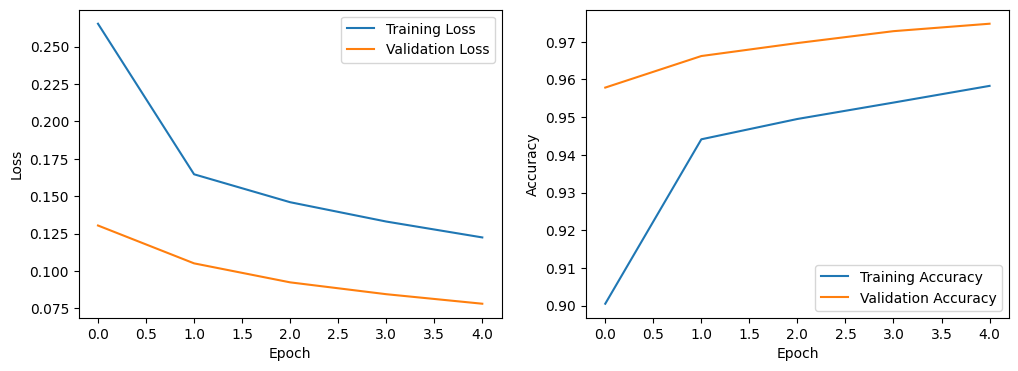

In [84]:
# ploat all
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(all_train_accs, label='Training Accuracy')
plt.plot(all_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [88]:
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        text, target = batch
        inputs = model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        pred = model.bert(**inputs).last_hidden_state[:, 0, :].detach().cpu().numpy()
        target = target.argmax(dim=-1).detach().cpu().numpy()
        embeddings.extend(pred)
        labels.extend(target)

embeddings = np.array(embeddings)
labels = np.array(labels)

100%|██████████| 134/134 [00:08<00:00, 16.30it/s]


In [89]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

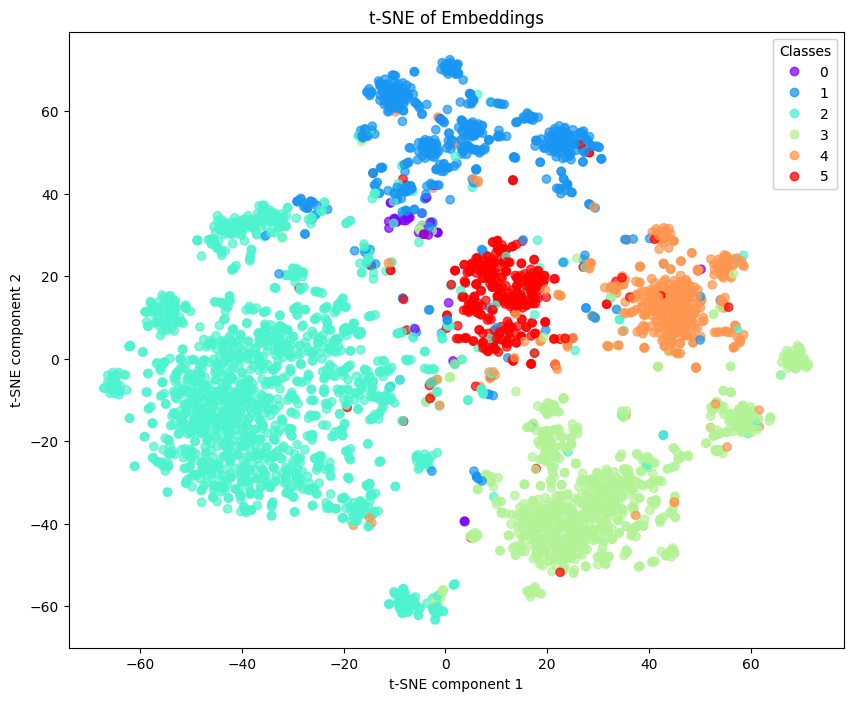

In [90]:
# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='rainbow', alpha=0.7)

# Add a legend
legend = plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
plt.gca().add_artist(legend)

# Add title and labels
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")

# Show plot
plt.show()